In [2]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
warnings.simplefilter("ignore")
df = pd.read_csv("test.csv",encoding='ISO-8859-1')
df.head(10)
messages = df[['text','sentiment']]
messages.isna().sum()
messages.dropna(inplace=True)
lm = WordNetLemmatizer()
tf = TfidfVectorizer(max_features=1000)
corpus = []
for i in range(len(messages)):
    review = re.sub('[^a-zA-Z]',' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    review = [lm.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
X = tf.fit_transform(corpus)

In [6]:
messages['clean_text'] = corpus

In [8]:
from sklearn.preprocessing import LabelEncoder
import torch 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [9]:
le = LabelEncoder()
y = le.fit_transform(messages['sentiment'])

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X.toarray(),y,test_size=0.3,random_state=42)

In [11]:
from torch.utils.data import Dataset,DataLoader

In [18]:
class SentimentDataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X,dtype =torch.float32)
        self.y = torch.tensor(y,dtype = torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
train_data = SentimentDataset(X_train,y_train)
test_data = SentimentDataset(X_test,y_test)

In [20]:
train_loader = DataLoader(dataset = train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset = test_data,batch_size =64)

In [22]:
class SentimentNet(nn.Module):
    def __init__(self,input_dim):
        super(SentimentNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,3)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
NNmodel = SentimentNet(input_dim = X.shape[1])

In [24]:
import torch.optim as optim 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(NNmodel.parameters(),lr=0.1)

In [25]:
epochs =25
for epoch in range(epochs):
    epoch_loss =0
    NNmodel.train()
    for inputs, labels in train_loader:
        labels = labels.long()
        outputs = NNmodel(inputs)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/25, Loss: 1.0533
Epoch 2/25, Loss: 0.8458
Epoch 3/25, Loss: 0.7479
Epoch 4/25, Loss: 0.6825
Epoch 5/25, Loss: 0.6167
Epoch 6/25, Loss: 0.5269
Epoch 7/25, Loss: 0.5145
Epoch 8/25, Loss: 0.4591
Epoch 9/25, Loss: 0.4387
Epoch 10/25, Loss: 0.4549
Epoch 11/25, Loss: 0.4650
Epoch 12/25, Loss: 0.5207
Epoch 13/25, Loss: 0.5259
Epoch 14/25, Loss: 0.4216
Epoch 15/25, Loss: 0.4708
Epoch 16/25, Loss: 0.4743
Epoch 17/25, Loss: 0.4716
Epoch 18/25, Loss: 0.4153
Epoch 19/25, Loss: 0.4449
Epoch 20/25, Loss: 0.4602
Epoch 21/25, Loss: 0.4129
Epoch 22/25, Loss: 0.4165
Epoch 23/25, Loss: 0.3483
Epoch 24/25, Loss: 0.3630
Epoch 25/25, Loss: 0.3565


In [46]:
correct =0
total =0
NNmodel.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.long()
        outputs = NNmodel(inputs)
        _,predicted = torch.max(outputs,1)
        total+= labels.size(0)
        correct += (predicted==labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")   

Test Accuracy: 60.13%


In [48]:
def preprocess(text):
    review = re.sub('[^a-zA-Z]',' ',text) 
    review = review.lower()
    review = review.split()
    review = [lm.lemmatize(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [50]:
def predict_sentiment(input_text):
    prediction ={ 0: 'Neutral',
                1: 'Negative',
                 2 :'Positive'
}
                 
    text = preprocess(input_text)
    vec = tf.transform([text]).toarray()
    tensor  = torch.tensor(vec,dtype = torch.float32)
    NNmodel.eval()
    with torch.no_grad():
        output = NNmodel(tensor)
        _, predicted = torch.max(output, 1)
        return prediction[predicted.item()]
    

In [52]:
user_input = input("Enter a sentence to check sentiment: ")
sentiment = predict_sentiment(user_input)
print(f"The sentiment of the input is: {sentiment}")

Enter a sentence to check sentiment:  the service was really good


The sentiment of the input is: Negative


In [54]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [56]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier (SVC)': SVC(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoost': GradientBoostingClassifier()
}

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X.toarray(),y,test_size=0.3,random_state=42)

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

    

In [61]:
def performace_check(models):
    for name, model in models.items():
        print(f"Training the {name} model")
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test,y_pred)
        report = classification_report(y_test,y_pred)
        print(f"{name} model's accuracy is {acc:.2f}")
        print(f"Classification report is \n{report}")
        cm = confusion_matrix(y_test,y_pred)
        plt.figure(figsize = (6,4))
        sns.heatmap(cm,annot=True, fmt="d", cmap="Blues", xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative', 'Neutral','Positive'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion matrix - {name}")
        plt.tight_layout()
        plt.show()
    

In [64]:
param_grid={
     'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Support Vector Classifier (SVC)': {
        'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
    },
    'Naive Bayes': {},  
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    },
    'AdaBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1]
    },
    'GradientBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }
}

best_models={}

In [66]:
for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")
    params = param_grid.get(name,{})
    if params:
        grid = GridSearchCV(model,params,cv=3,scoring='accuracy',n_jobs=-1,verbose=2)
        grid.fit(X_train,y_train)
        best_models[name] = grid.best_estimator_
        
    


Tuning hyperparameters for Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Tuning hyperparameters for Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Tuning hyperparameters for Support Vector Classifier (SVC)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Tuning hyperparameters for Naive Bayes...

Tuning hyperparameters for K-Nearest Neighbors...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Tuning hyperparameters for Decision Tree...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Tuning hyperparameters for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tuning hyperparameters for AdaBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Tuning hyperparameters for GradientBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


Training the Logistic Regression model
Logistic Regression model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.70      0.49      0.58       306
           1       0.57      0.75      0.65       423
           2       0.75      0.67      0.71       332

    accuracy                           0.65      1061
   macro avg       0.68      0.64      0.65      1061
weighted avg       0.67      0.65      0.65      1061



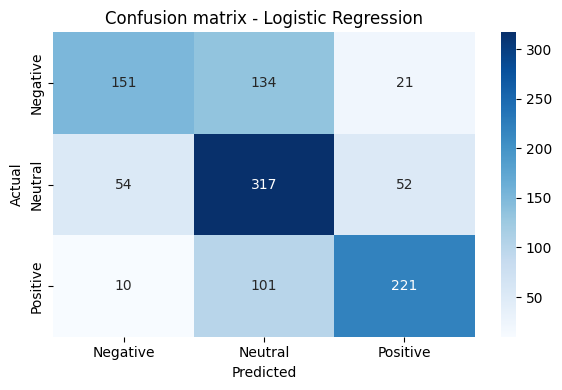

Training the Random Forest model
Random Forest model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.71      0.48      0.57       306
           1       0.60      0.74      0.66       423
           2       0.69      0.69      0.69       332

    accuracy                           0.65      1061
   macro avg       0.67      0.64      0.64      1061
weighted avg       0.66      0.65      0.65      1061



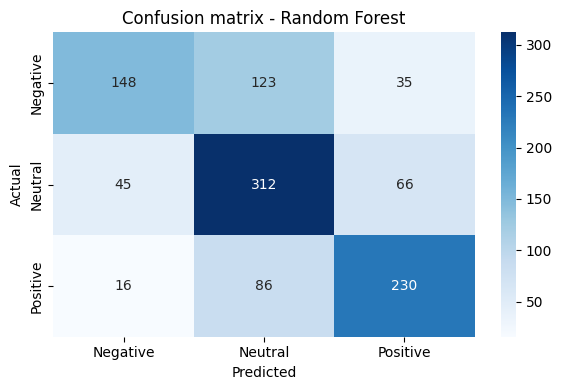

Training the Support Vector Classifier (SVC) model
Support Vector Classifier (SVC) model's accuracy is 0.62
Classification report is 
              precision    recall  f1-score   support

           0       0.73      0.38      0.50       306
           1       0.54      0.84      0.65       423
           2       0.79      0.58      0.67       332

    accuracy                           0.62      1061
   macro avg       0.69      0.60      0.61      1061
weighted avg       0.67      0.62      0.61      1061



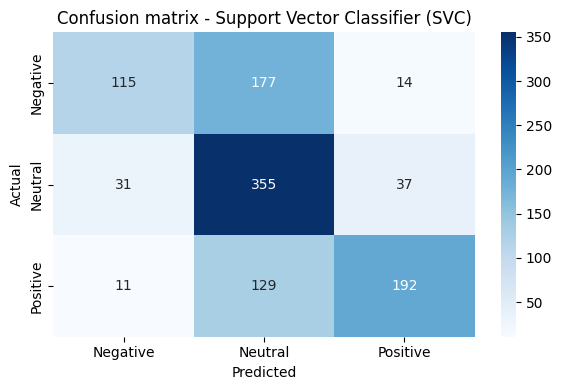

Training the Naive Bayes model
Naive Bayes model's accuracy is 0.45
Classification report is 
              precision    recall  f1-score   support

           0       0.46      0.61      0.53       306
           1       0.43      0.15      0.22       423
           2       0.45      0.69      0.55       332

    accuracy                           0.45      1061
   macro avg       0.45      0.48      0.43      1061
weighted avg       0.44      0.45      0.41      1061



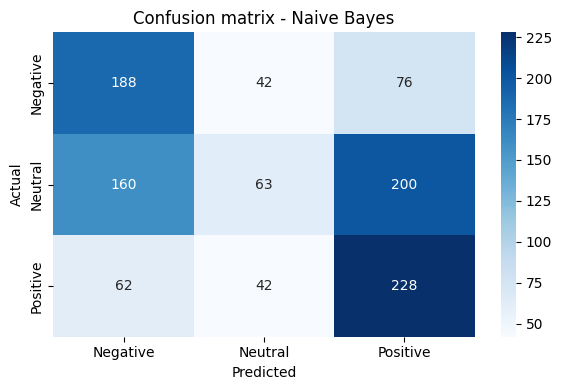

Training the K-Nearest Neighbors model
K-Nearest Neighbors model's accuracy is 0.46
Classification report is 
              precision    recall  f1-score   support

           0       0.66      0.14      0.23       306
           1       0.43      0.95      0.59       423
           2       0.80      0.14      0.24       332

    accuracy                           0.46      1061
   macro avg       0.63      0.41      0.35      1061
weighted avg       0.61      0.46      0.38      1061



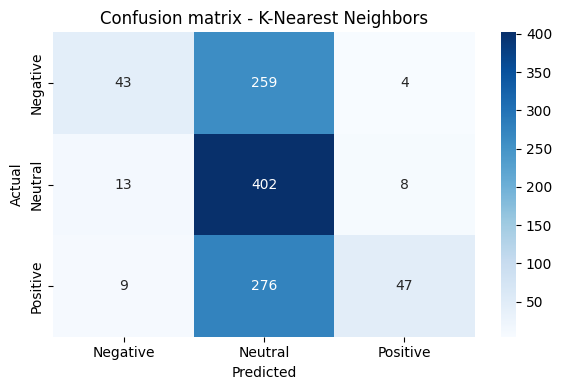

Training the Decision Tree model
Decision Tree model's accuracy is 0.60
Classification report is 
              precision    recall  f1-score   support

           0       0.57      0.54      0.56       306
           1       0.58      0.57      0.58       423
           2       0.63      0.67      0.65       332

    accuracy                           0.60      1061
   macro avg       0.59      0.60      0.60      1061
weighted avg       0.59      0.60      0.59      1061



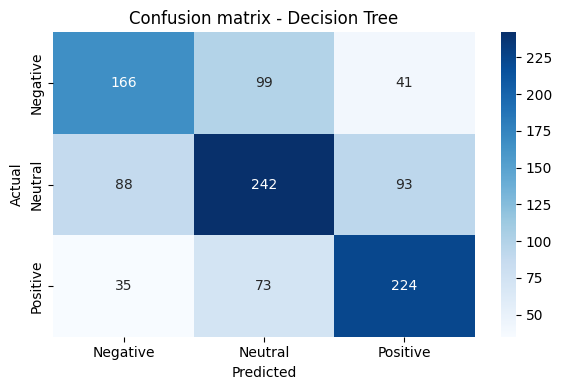

Training the XGBoost model
XGBoost model's accuracy is 0.64
Classification report is 
              precision    recall  f1-score   support

           0       0.71      0.44      0.54       306
           1       0.57      0.78      0.66       423
           2       0.72      0.64      0.68       332

    accuracy                           0.64      1061
   macro avg       0.67      0.62      0.63      1061
weighted avg       0.66      0.64      0.63      1061



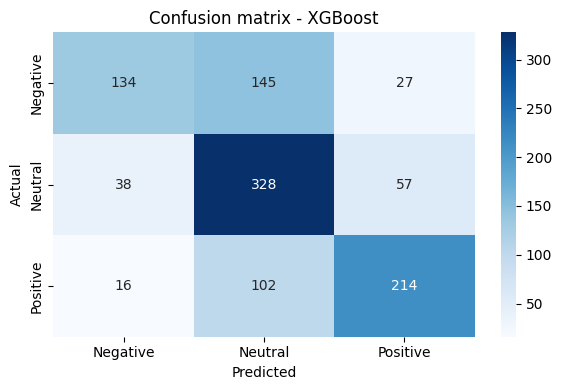

Training the AdaBoost model
AdaBoost model's accuracy is 0.52
Classification report is 
              precision    recall  f1-score   support

           0       0.83      0.07      0.12       306
           1       0.46      0.93      0.61       423
           2       0.79      0.42      0.55       332

    accuracy                           0.52      1061
   macro avg       0.69      0.47      0.43      1061
weighted avg       0.67      0.52      0.45      1061



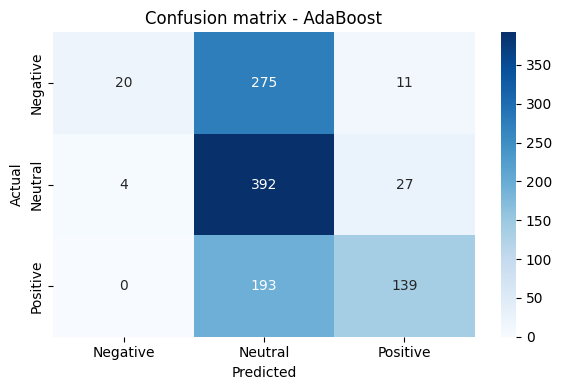

Training the GradientBoost model
GradientBoost model's accuracy is 0.63
Classification report is 
              precision    recall  f1-score   support

           0       0.78      0.36      0.49       306
           1       0.55      0.86      0.67       423
           2       0.78      0.59      0.67       332

    accuracy                           0.63      1061
   macro avg       0.70      0.60      0.61      1061
weighted avg       0.69      0.63      0.62      1061



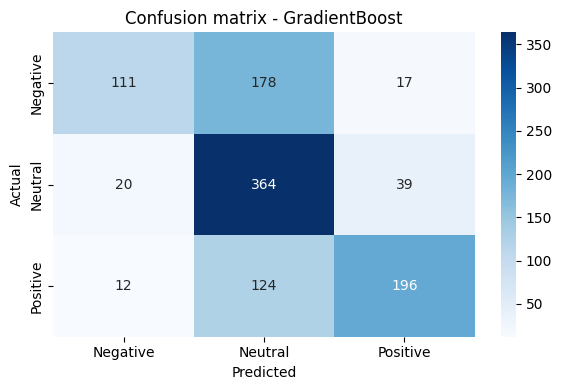

Training the Logistic Regression model
Logistic Regression model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.70      0.49      0.58       306
           1       0.57      0.75      0.65       423
           2       0.75      0.67      0.71       332

    accuracy                           0.65      1061
   macro avg       0.68      0.64      0.65      1061
weighted avg       0.67      0.65      0.65      1061



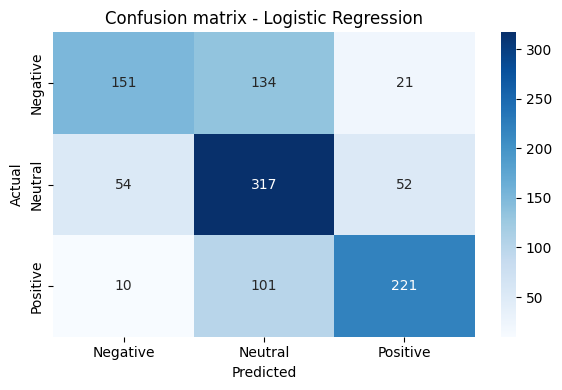

Training the Random Forest model
Random Forest model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.71      0.49      0.58       306
           1       0.60      0.74      0.67       423
           2       0.70      0.69      0.69       332

    accuracy                           0.65      1061
   macro avg       0.67      0.64      0.65      1061
weighted avg       0.66      0.65      0.65      1061



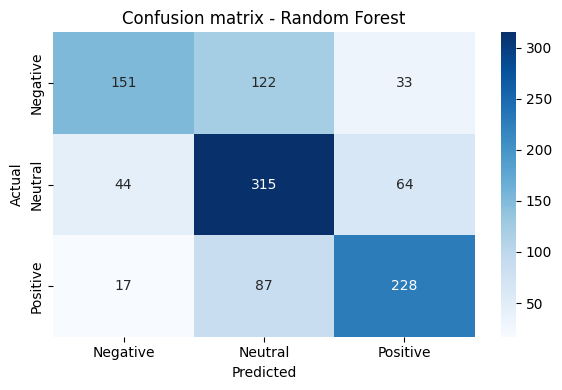

Training the Support Vector Classifier (SVC) model
Support Vector Classifier (SVC) model's accuracy is 0.64
Classification report is 
              precision    recall  f1-score   support

           0       0.69      0.48      0.57       306
           1       0.57      0.77      0.65       423
           2       0.76      0.63      0.69       332

    accuracy                           0.64      1061
   macro avg       0.67      0.63      0.64      1061
weighted avg       0.66      0.64      0.64      1061



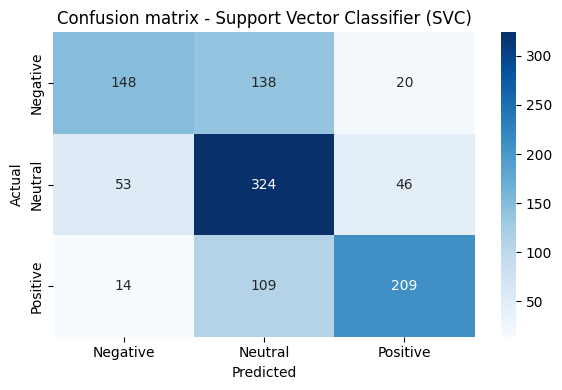

Training the K-Nearest Neighbors model
K-Nearest Neighbors model's accuracy is 0.46
Classification report is 
              precision    recall  f1-score   support

           0       0.66      0.12      0.20       306
           1       0.42      0.96      0.59       423
           2       0.85      0.12      0.22       332

    accuracy                           0.46      1061
   macro avg       0.65      0.40      0.34      1061
weighted avg       0.63      0.46      0.36      1061



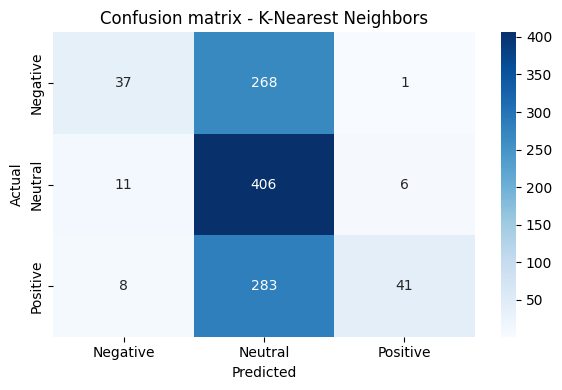

Training the Decision Tree model
Decision Tree model's accuracy is 0.61
Classification report is 
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       306
           1       0.59      0.58      0.59       423
           2       0.65      0.68      0.67       332

    accuracy                           0.61      1061
   macro avg       0.61      0.61      0.61      1061
weighted avg       0.60      0.61      0.61      1061



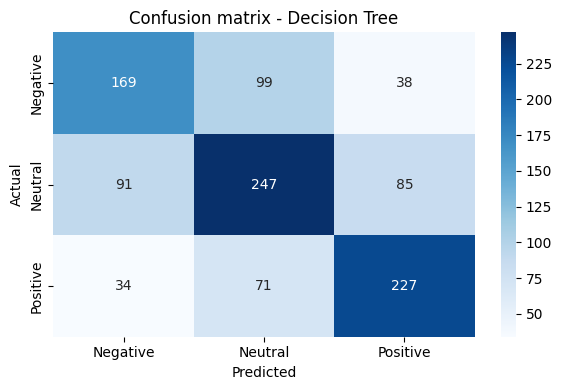

Training the XGBoost model
XGBoost model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.75      0.42      0.54       306
           1       0.57      0.81      0.67       423
           2       0.75      0.64      0.69       332

    accuracy                           0.65      1061
   macro avg       0.69      0.62      0.63      1061
weighted avg       0.68      0.65      0.64      1061



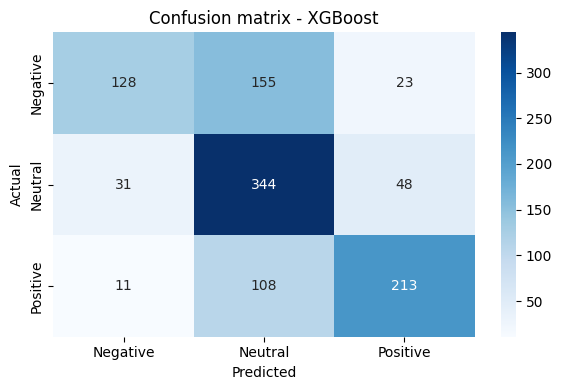

Training the AdaBoost model
AdaBoost model's accuracy is 0.48
Classification report is 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       306
           1       0.43      0.95      0.60       423
           2       0.76      0.31      0.44       332

    accuracy                           0.48      1061
   macro avg       0.40      0.42      0.35      1061
weighted avg       0.41      0.48      0.38      1061



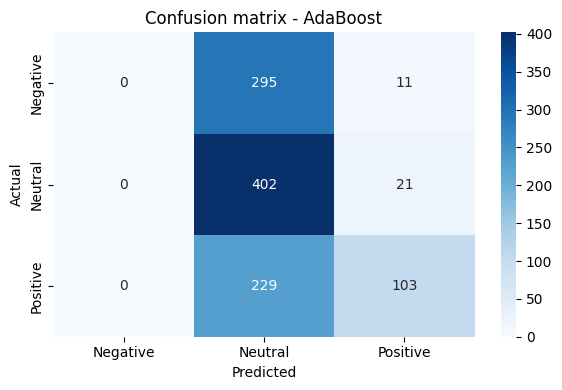

Training the GradientBoost model
GradientBoost model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.76      0.44      0.56       306
           1       0.57      0.83      0.68       423
           2       0.77      0.63      0.69       332

    accuracy                           0.65      1061
   macro avg       0.70      0.63      0.64      1061
weighted avg       0.69      0.65      0.65      1061



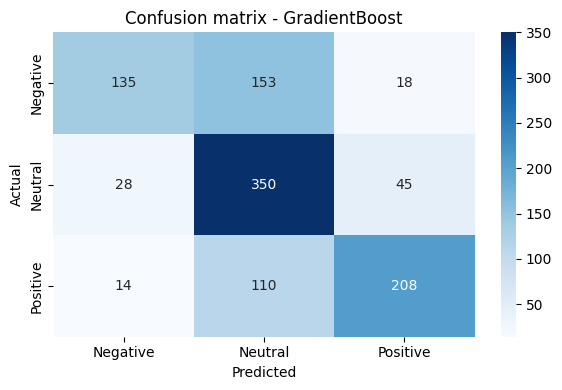

In [350]:
performace_check(models)


Training the Logistic Regression model
Logistic Regression model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.70      0.49      0.58       306
           1       0.57      0.75      0.65       423
           2       0.75      0.67      0.71       332

    accuracy                           0.65      1061
   macro avg       0.68      0.64      0.65      1061
weighted avg       0.67      0.65      0.65      1061



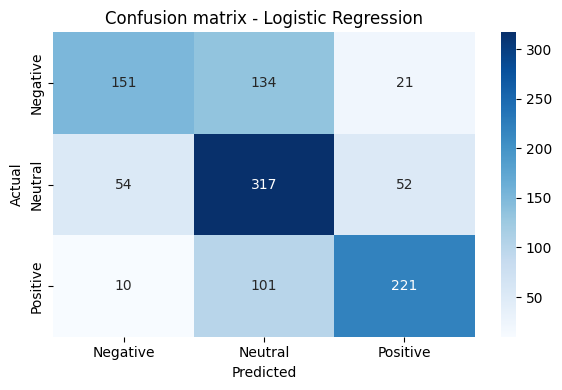

Training the Random Forest model
Random Forest model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.71      0.48      0.57       306
           1       0.60      0.74      0.66       423
           2       0.69      0.69      0.69       332

    accuracy                           0.65      1061
   macro avg       0.67      0.64      0.64      1061
weighted avg       0.66      0.65      0.64      1061



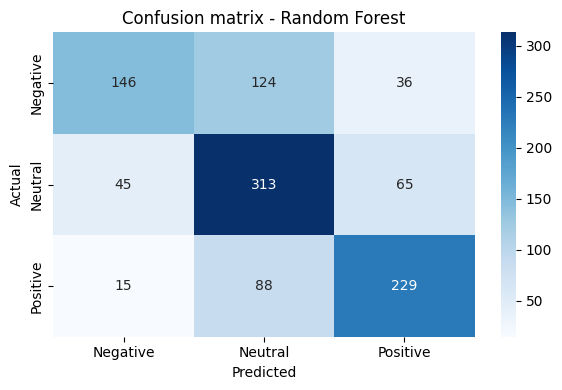

Training the Support Vector Classifier (SVC) model
Support Vector Classifier (SVC) model's accuracy is 0.64
Classification report is 
              precision    recall  f1-score   support

           0       0.69      0.48      0.57       306
           1       0.57      0.77      0.65       423
           2       0.76      0.63      0.69       332

    accuracy                           0.64      1061
   macro avg       0.67      0.63      0.64      1061
weighted avg       0.66      0.64      0.64      1061



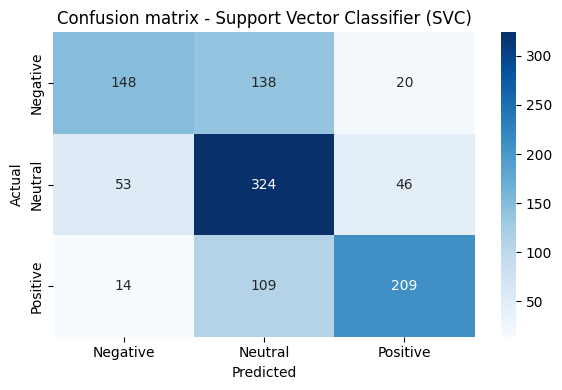

Training the K-Nearest Neighbors model
K-Nearest Neighbors model's accuracy is 0.46
Classification report is 
              precision    recall  f1-score   support

           0       0.66      0.12      0.20       306
           1       0.42      0.96      0.59       423
           2       0.85      0.12      0.22       332

    accuracy                           0.46      1061
   macro avg       0.65      0.40      0.34      1061
weighted avg       0.63      0.46      0.36      1061



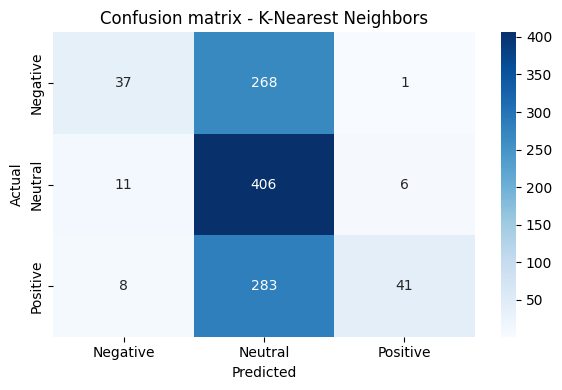

Training the Decision Tree model
Decision Tree model's accuracy is 0.60
Classification report is 
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       306
           1       0.58      0.58      0.58       423
           2       0.65      0.67      0.66       332

    accuracy                           0.60      1061
   macro avg       0.60      0.60      0.60      1061
weighted avg       0.60      0.60      0.60      1061



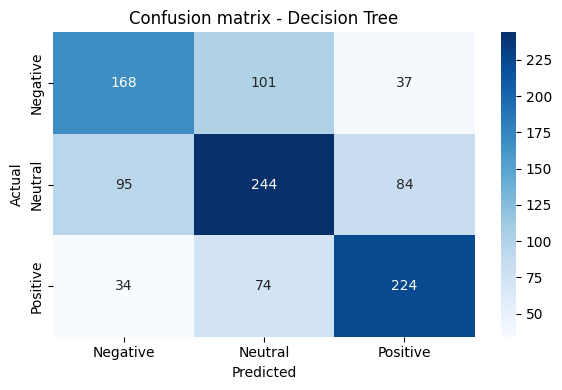

Training the XGBoost model
XGBoost model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.75      0.42      0.54       306
           1       0.57      0.81      0.67       423
           2       0.75      0.64      0.69       332

    accuracy                           0.65      1061
   macro avg       0.69      0.62      0.63      1061
weighted avg       0.68      0.65      0.64      1061



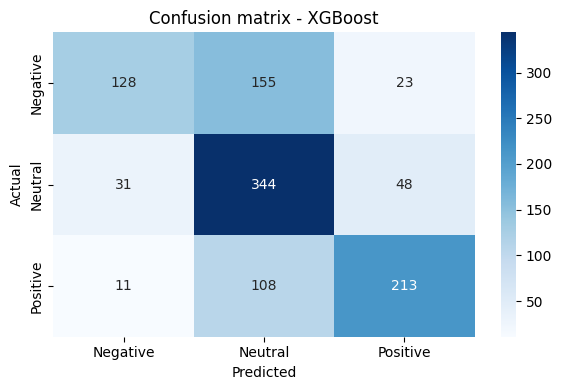

Training the AdaBoost model
AdaBoost model's accuracy is 0.48
Classification report is 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       306
           1       0.43      0.95      0.60       423
           2       0.76      0.31      0.44       332

    accuracy                           0.48      1061
   macro avg       0.40      0.42      0.35      1061
weighted avg       0.41      0.48      0.38      1061



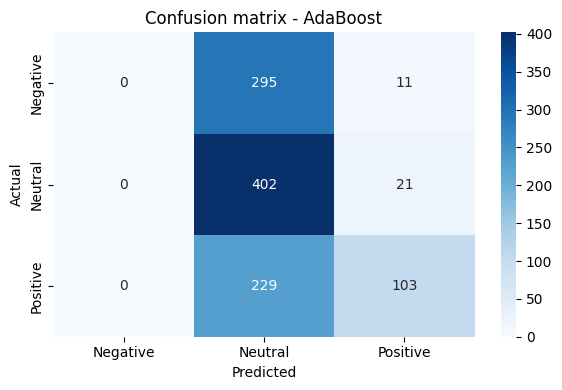

Training the GradientBoost model
GradientBoost model's accuracy is 0.65
Classification report is 
              precision    recall  f1-score   support

           0       0.76      0.44      0.56       306
           1       0.56      0.82      0.67       423
           2       0.75      0.62      0.68       332

    accuracy                           0.65      1061
   macro avg       0.69      0.62      0.63      1061
weighted avg       0.68      0.65      0.64      1061



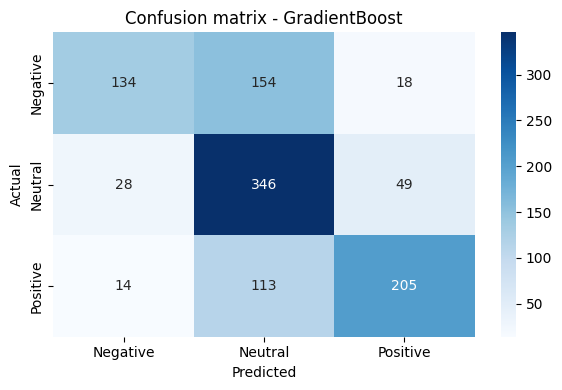

In [351]:
performace_check(best_models)

In [78]:
 prediction ={ 0: 'Negative',
                1: 'Neutral',
                2 :'Positive'
}

In [92]:
text = input("Enter the sentence: ")
process_text = preprocess(text)
vec = tf.transform([text]).toarray()

Enter the sentence:  you son of a bitch, you aint gonna make it till night


In [94]:
for name,model in best_models.items():
    print(f"Prediction from model {name}")
    pred = model.predict(vec)
    print(f"The sentence is {prediction[pred.item()]}")

print("Prediction from NN")
sentiment = predict_sentiment(text)
print(f"The sentiment of the input is: {sentiment}")

    
    
    

Prediction from model Logistic Regression
The sentence is Neutral
Prediction from model Random Forest
The sentence is Neutral
Prediction from model Support Vector Classifier (SVC)
The sentence is Neutral
Prediction from model K-Nearest Neighbors
The sentence is Neutral
Prediction from model Decision Tree
The sentence is Positive
Prediction from model XGBoost
The sentence is Neutral
Prediction from model AdaBoost
The sentence is Neutral
Prediction from model GradientBoost
The sentence is Neutral
Prediction from NN
The sentiment of the input is: Negative


In [96]:
df.head(100)

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...
95,71fa60d9ff,was so excited to eat the wartermelon i bought...,neutral,night,70-100,Lesotho,2142249.0,30360.0,71.0
96,c238c4dbb7,i just watched Marley & Me...i cried so hard!,negative,morning,0-20,Liberia,5057681.0,96320.0,53.0
97,dc73e85417,Take antibacterial to school to clean your han...,neutral,noon,21-30,Libya,6871292.0,1759540.0,4.0
98,af63915fa9,I`m leaving work now. Trying to decide if I re...,neutral,night,31-45,Liechtenstein,38128.0,160.0,238.0
